<a href="https://colab.research.google.com/github/yurikr/Food101/blob/master/Food_101_2007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food - 101 challenge by Yuri Kryzhanovski, 20.07.2020

**Why I selected this challenge?**


The answer is because I've done similar task before. I was able to predict 104 different flowers on TPU. I used DenseNet201 and B7, B5 cross-validations.
https://www.kaggle.com/c/flower-classification-with-tpus

The dataset provided contained 104 different flowers and had roughly 1000   images per each flower. Some of the flowers had smaller sample, some larger. So I created my own balanced dataset with almost twice of the tf records where all flowers were equally represented.

The main takeaways from this:

* TPU allowed to train all 3 models in just 3 hours.
*  Batch of 128 images 512 by 512 pixels was used.
*  The best results on private board where achieved by models trained on combined training and validation datasets.
*  Proper augmentations and customized learning rate decay were also great contributors to the good score. 

**What I will use for this challenge?**

* No TPUs
* No upsampling or weighthed losses - dataset seems mostly balanced
* Batch size 16
* Images resized to 224 by 224 with standard normalization
* Augmentation (flip horizoantally, rotate, shear, shift, zoom)
* B5 EfficientNet pretrained on "noisy-student" weights to achive 85% plus accuracy on test set
* Dropouts, regularizers






     


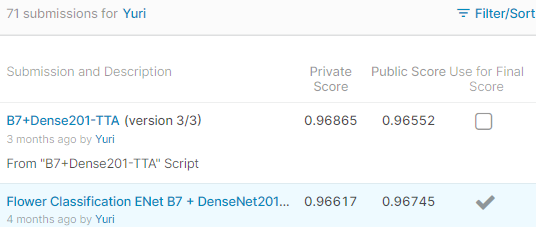


While I was happy with my results, accuracy of the first place solution was above 98%!

# Data preprocessing and EDA


**Download and extract Dataset**

In [1]:
# Check if GPU is enabled
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())

# Helper function to download data and extract
import os
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

# Download data and extract it to folder
get_data_extract()

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-101/images/cannoli/3452001.jpg
food-101/images/cannoli/

In [2]:
# Check the extracted dataset folder
!ls food-101/

images	license_agreement.txt  meta  README.txt


In [3]:
# Check image folder
import os
os.listdir('food-101/images')

['club_sandwich',
 'steak',
 'peking_duck',
 'sushi',
 'lasagna',
 'huevos_rancheros',
 'dumplings',
 'bread_pudding',
 'omelette',
 'french_onion_soup',
 'cup_cakes',
 'bibimbap',
 'hot_dog',
 'red_velvet_cake',
 'spaghetti_bolognese',
 'lobster_bisque',
 'chocolate_cake',
 'paella',
 'mussels',
 'apple_pie',
 'french_fries',
 'pork_chop',
 'pizza',
 'baklava',
 'tacos',
 'macarons',
 'clam_chowder',
 'nachos',
 'beef_carpaccio',
 'waffles',
 'hot_and_sour_soup',
 'guacamole',
 'lobster_roll_sandwich',
 'beef_tartare',
 'gyoza',
 'fried_rice',
 'macaroni_and_cheese',
 'pancakes',
 'crab_cakes',
 'onion_rings',
 'foie_gras',
 'grilled_salmon',
 'spaghetti_carbonara',
 'eggs_benedict',
 'hamburger',
 'breakfast_burrito',
 'donuts',
 'churros',
 'poutine',
 'seaweed_salad',
 'chocolate_mousse',
 'miso_soup',
 'scallops',
 'tuna_tartare',
 'pad_thai',
 'hummus',
 'prime_rib',
 'french_toast',
 'ceviche',
 'samosa',
 'shrimp_and_grits',
 'spring_rolls',
 'strawberry_shortcake',
 'edamame',

In [4]:
#check metadata
os.listdir('food-101/meta')

['train.json',
 'labels.txt',
 'train.txt',
 'test.json',
 'classes.txt',
 'test.txt']

In [5]:
!cat food-101/meta/classes.txt | wc # 101 classes

    101     101    1184


In [6]:
!cat food-101/meta/train.txt | wc # 75750 train images

  75750   75750 1468812


In [7]:
!cat food-101/meta/test.txt | wc # 25250 test images

  25250   25250  489429


**Visualize Images**

Note that their size is not identical

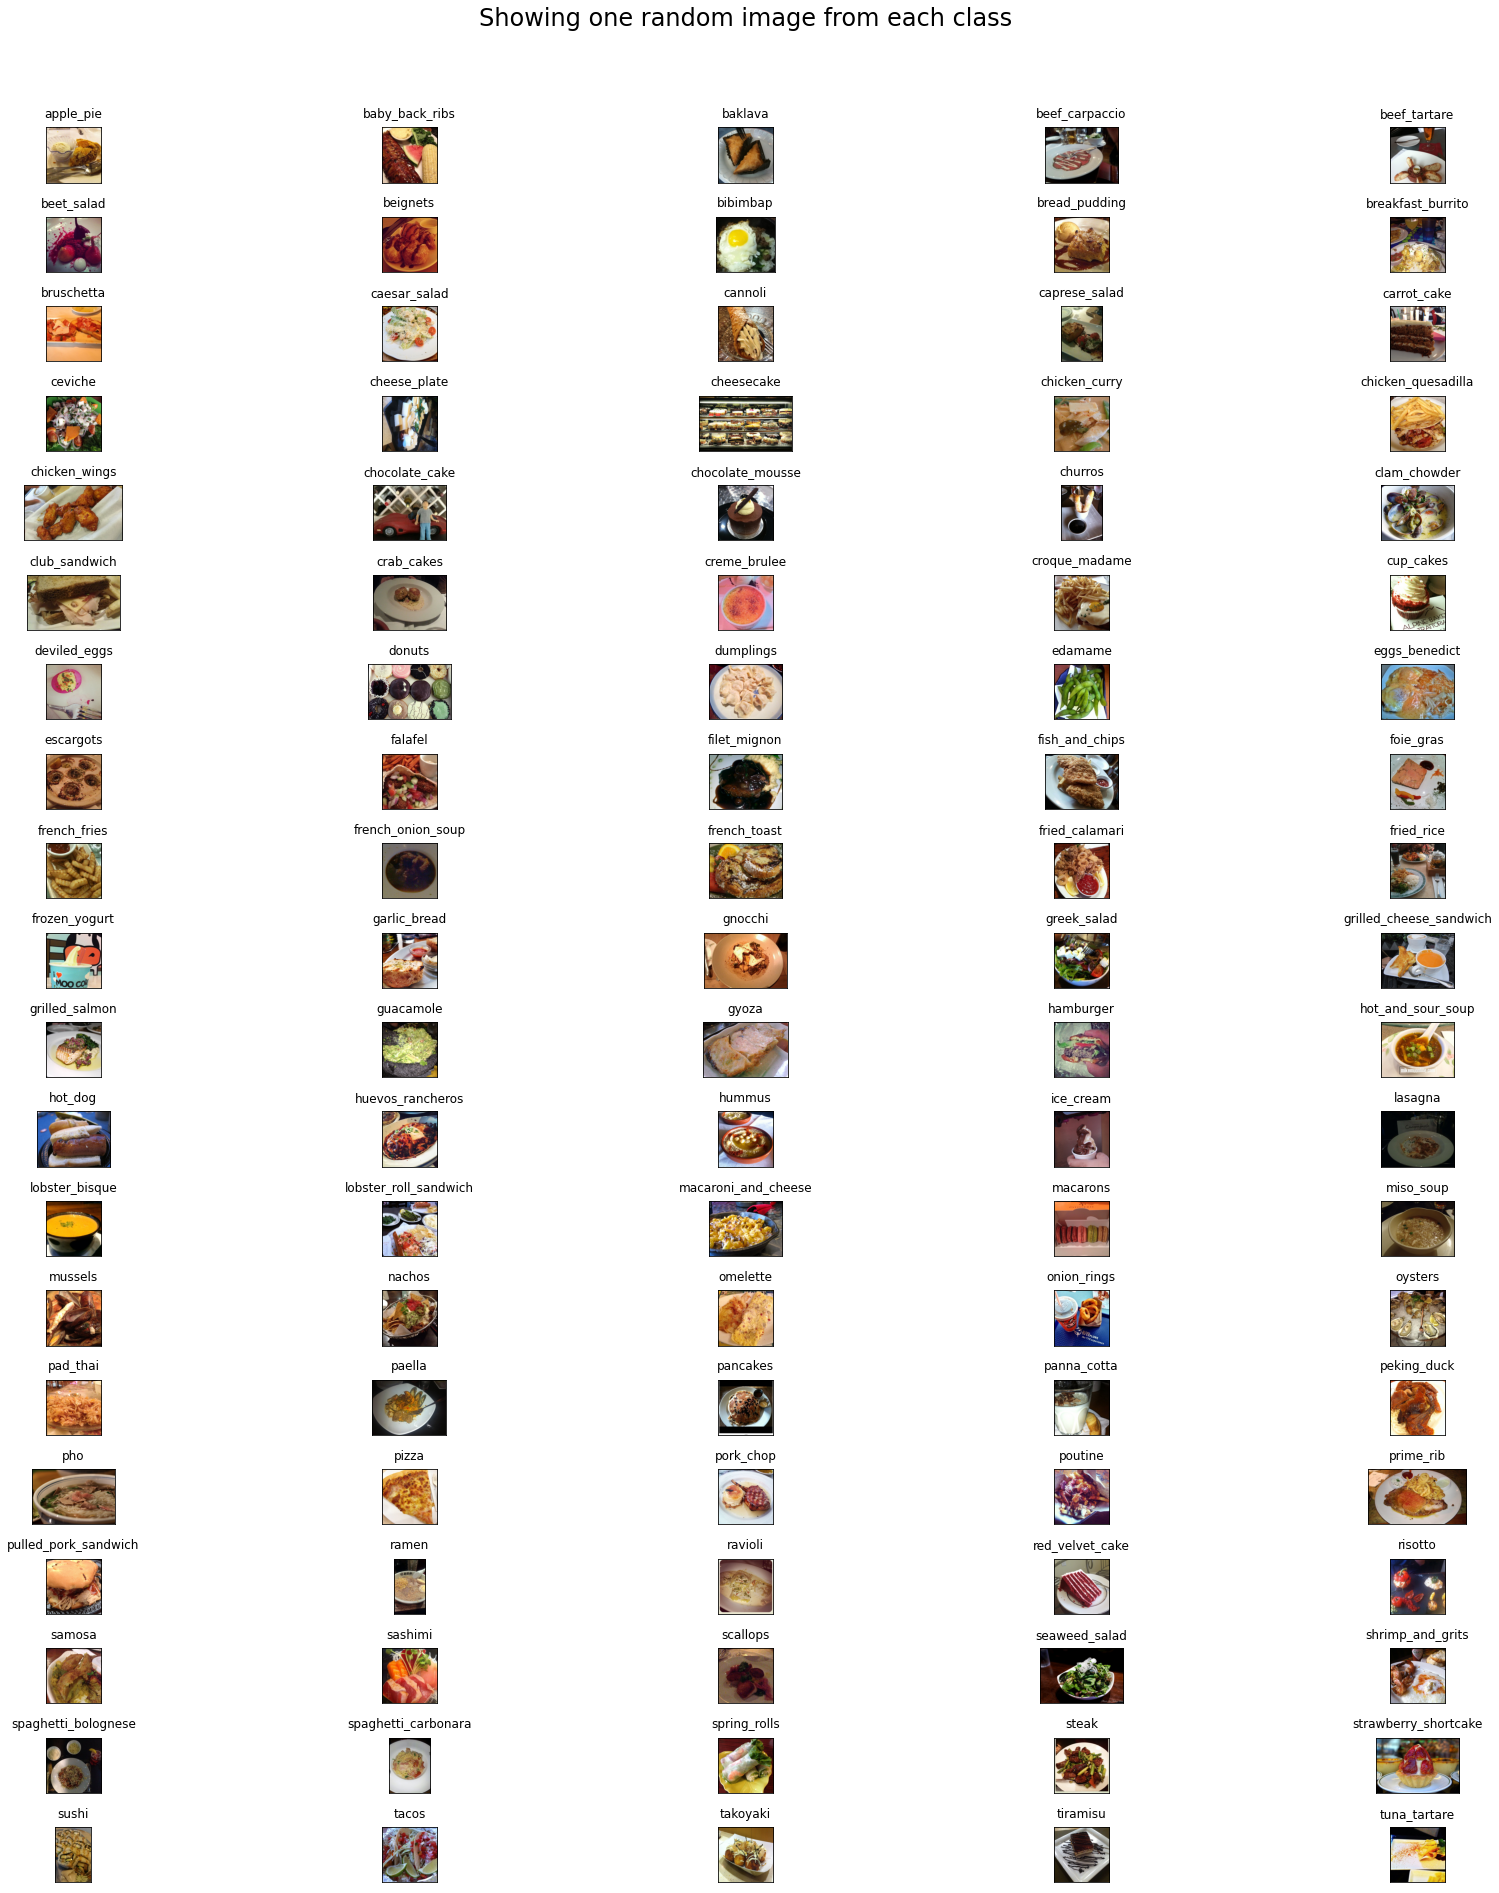

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
import os

# Visualize the data, showing one image per class from 100 classes
rows = 20
cols = 5
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


**Let's check that dataset is balanced**
We should have the same number of files in each folder that belongs to the same food. Otherwise we will need to equalize the contributions of different foods to the loss function or equalize number of samples.


In [9]:
expectedCount  =1000

for i, foodPath in enumerate(foods_sorted):
  food_files = os.listdir(os.path.join(data_dir, foodPath))
  if (len(food_files) != expectedCount):
    print( "Dataset not balanced")

print ("Dataset seems balanced - at least each folder has the same size ( There is no time now to check properly image by image in every folder)")


Dataset seems balanced - at least each folder has the same size ( There is no time now to check properly image by image in every folder)


# Split dataset to train and test folders according to metadata

In [10]:
from shutil import copy
from shutil import copytree, rmtree

# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")


In [11]:
# Prepare train folder
prepare_data('food-101/meta/train.txt', 'food-101/images', 'train')


Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying images into  croque_madam

In [12]:
# Prepare test folder
prepare_data('food-101/meta/test.txt', 'food-101/images', 'test')


Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying images into  croque_madam

# Create Train and Test Generator

In [19]:
from keras.preprocessing.image import ImageDataGenerator

#!ls food-101/images

batch_size = 16
target_size = (224,224)

# train data should be centered and standardized and augmented to prevent train set overfittings

train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest",
    horizontal_flip=True)

# validation data should be centered and standardized

valid_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    fill_mode="nearest")

train_generator = train_datagen.flow_from_directory(
        'train',
        shuffle =True,
        target_size=target_size,
        batch_size=batch_size)

validation_generator = valid_datagen.flow_from_directory(
        'test',
        shuffle =True,
        target_size=target_size,
        batch_size=batch_size) 

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


In [14]:
print ('Few of the images will not be processed the numbers above cannot be divided by batch size without reminder: ', len(validation_generator)*batch_size, len(train_generator)*batch_size)

Few of the images will not be processed the numbers above cannot be divided by batch size without reminder:  25264 75760


**Custom Leaning Rate With exponential decay**

Learning rate schedule: 0.0001 to 0.0001 to 5e-06


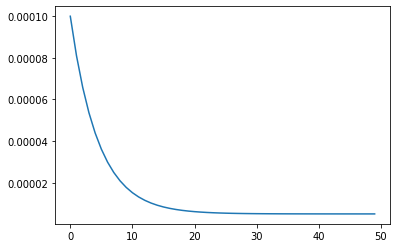

In [18]:
#As training processes the learning rate is decreased by a factor of 0.8

LR_MAX = 1e-4
LR_MIN = 5e-6
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

EPOCHS = 50

def lrfn(epoch):
    if epoch < LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch -  LR_SUSTAIN_EPOCHS) + LR_MIN
        

    return lr
    
rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))   

#print(y)


# Install and use EfficientNet B5


In [20]:
!pip install -q efficientnet
import efficientnet.tfkeras as efn

I did tried to train DenseNet201 as well, but the same process resulted in training overfitting, so decided to stick with EfficientNet B5.

In [21]:
#import everything I need

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np



In [23]:
#Connect to colab to save weights after each epoch

from google.colab import drive
drive.mount('content')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at content


In [ ]:
!ls 'content/My Drive/MachineLearning/food101'



b5-001-0.497795-0.792396.h5  b5-007-0.857386-0.880436.h5
b5-002-0.699776-0.834852.h5  b5-008-0.838680-0.849604.h5
b5-003-0.759023-0.857069.h5  b5-008-0.871815-0.884634.h5
b5-004-0.780220-0.827129.h5  b5-009-0.844929-0.847921.h5
b5-004-0.796145-0.867208.h5  b5-009-0.880620-0.887089.h5
b5-005-0.802101-0.835347.h5  b5-010-0.848966-0.848119.h5
b5-005-0.822244-0.872713.h5  b5-010-0.891168-0.885228.h5
b5-006-0.814741-0.842178.h5  b5-011-0.855556-0.854059.h5
b5-006-0.841531-0.878495.h5  b7.h5
b5-007-0.828779-0.844158.h5  dense201.h5


In [24]:
n_classes = 101

K.clear_session()

img_width, img_height = 224, 224

"""
B5 will be loaded with noisy-student weights exlcluding top layer.
Final output will be 101 clasees with softmax activation.
Dropout and regularization is added to prevent training outfitting
GlobalAveragePooling followed by Dense to 512 outputs is used to make the model deeper and allowed additional feature detections
"""

b5 = efn.EfficientNetB5(weights='noisy-student', include_top=False, input_shape=[img_width, img_height, 3])  # base model - B5
x = b5.output
x = GlobalAveragePooling2D()(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(n_classes, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=b5.input, outputs=predictions)

# Create model with Adam optimizer for gradient descent and categorical cross entropy loss 
model.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999, amsgrad=False), loss='categorical_crossentropy', metrics=['accuracy'])





115261440/115255328 [==============================] - 1s 0us/step


In [ ]:
#stop after 5 iterations if validation loss does not improve - can be removed

es_callback = tf.keras.callbacks.EarlyStopping(min_delta=0, patience=5, verbose=1, mode='auto', restore_best_weights=True)
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)



In [ ]:
#save best weights to my gdrive
model_checkpoint_callback = ModelCheckpoint('content/My Drive/MachineLearning/food101/'+ 'b5-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')


In [ ]:
#train for 10 epochs 
history = model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=10,
                    verbose=1,
                    callbacks=[lr_callback, es_callback, model_checkpoint_callback])



Instructions for updating:
Please use Model.fit, which supports generators.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/10
4735/4735 [==============================] - ETA: 0s - loss: 2.6158 - accuracy: 0.4978
Epoch 00001: val_loss improved from inf to 1.16895, saving model to content/My Drive/MachineLearning/food101/b5-001-0.497795-0.792396.h5
4735/4735 [==============================] - 1932s 408ms/step - loss: 2.6158 - accuracy: 0.4978 - val_loss: 1.1690 - val_accuracy: 0.7924 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 8.1e-05.
Epoch 2/10
4735/4735 [==============================] - ETA: 0s - loss: 1.4946 - accuracy: 0.6998
Epoch 00002: val_loss improved from 1.16895 to 0.89256, saving model to content/My Drive/MachineLearning/food101/b5-002-0.699776-0.834852.h5
4735/4735 [==============================] - 1894s 400ms/step - loss: 1.4946 - accuracy: 0.6998 - val_loss: 0.8926 - val_accuracy: 0.8349 - lr: 8.1000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 6.58000000000

# Explaining results

* As you may see because of the augmentation and regularizarions training model is underfitting on initial epochs. 
* As the training process training loss is falling faster then validation loss
* As the training process training accuracy does catch up.
* I did choose 10 epochs as kind of early stopping. At this moment validation loss/ accuracy reached plateau.
* Validation accuracy reached is almost 89%. It is way less then in TPU 97%  in kaggle competition, but there is no TPU, no big large batches,no images 512 by 512 pixels, no cross validations and much less time spent by me.
* Perhaps can reach 90% of accuracy if continuing training for another 20 epoch with ReduceLROnPLateau, patience 3 and lr adjustment rate 0.2-0.5

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

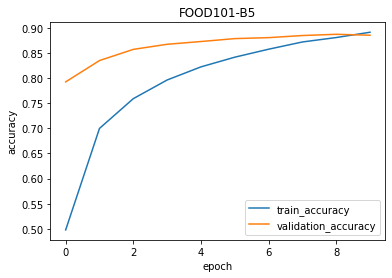

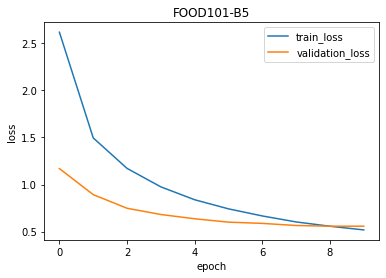

In [ ]:
plot_accuracy(history,'FOOD101-B5')
plot_loss(history,'FOOD101-B5')

**Visualize results**

In [37]:
model.load_weights('content/My Drive/MachineLearning/food101/b5-009-0.880620-0.887089.h5')

In [110]:

# generate predictions for validation dataset

batch_size=8

valid_datagen_norm = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    fill_mode="nearest")

valid_datage = ImageDataGenerator(
    fill_mode="nearest")

validation_generator_norm = valid_datagen.flow_from_directory(
        'test',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical') 


x,y = validation_generator_norm.next()
predict = model.predict_generator(validation_generator_norm,steps =  1)

Found 25250 images belonging to 101 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [111]:
predicted_indexes = np.argmax(predict, axis = 1)

In [112]:
predicted_indexes

array([84, 94, 86, 10, 76, 37, 88, 78])

risotto


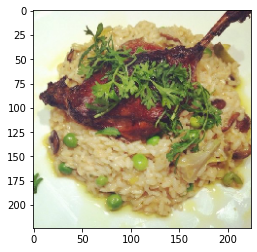

strawberry_shortcake


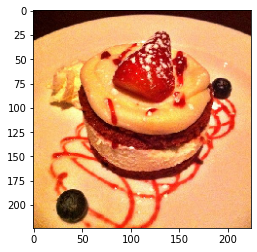

sashimi


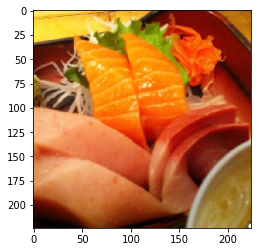

bruschetta


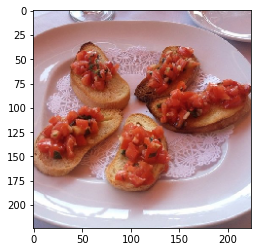

pizza


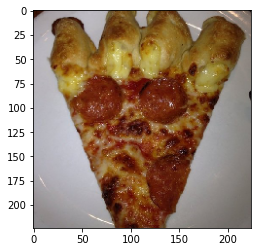

filet_mignon


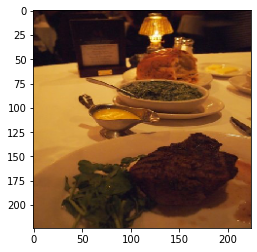

seaweed_salad


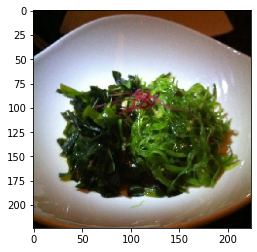

In [113]:

for i in range(0, len(predicted_indexes) - 1):

    image = x[i]/255
    label = foods_sorted[predicted_indexes[i]]
    plt.title = label
    print(label)
    plt.imshow(image)
    plt.show()